In [270]:
if False:
    import sys
    !{sys.executable} -m pip install requests
    !{sys.executable} -m pip install geopandas
    !{sys.executable} -m pip install matplotlib
    !{sys.executable} -m pip install networkx
    !{sys.executable} -m pip install folium

In [48]:
import os
import sys
import json
import glob
import folium
import requests
import datetime
import networkx as nx
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

In [2]:
apikey = 'JydUr1HO7ejqBhw0YP19W3b1GonFwmzr'

In [3]:
# Define coordinate reference system (CRS) codes
# WGS 84
WGS84 = {'init':'epsg:4326'}
# British National Grid
BNG = {'init':'epsg:27700'}

In [4]:
wfs_endpoint = ('https://osdatahubapi.os.uk/OSFeaturesAPI/wfs/v1')

params = {
    "key":"FtAS7OR45lE3AR78KxrdGpfYq8uAAV6K",
    "service":"WFS",
    "request":"GetFeature",
    "version":"2.0.0",
    "typeNames":"Highways_RoadLink",
    "outputFormat":"GEOJSON",
    "srsName":"urn:ogc:def:crs:EPSG::4326",
    "count":100,
    "startIndex":0,
    "filter":"<ogc:Filter><ogc:Intersects><ogc:PropertyName>SHAPE</ogc:PropertyName><gml:Polygon srsName='urn:ogc:def:crs:EPSG::4326'><gml:outerBoundaryIs><gml:LinearRing><gml:coordinates>-0.9178717664495366,50.989012935589244 -0.9223751250371492,50.9645569801383 -0.8959178933630483,50.95338802238439 -0.8618612440900222,50.95391993839533 -0.8452551093233751,50.967747617825694 -0.8483511683495237,50.9829887509967 -0.8787488387748397,50.99468204223871 -0.9178717664495366,50.989012935589244</gml:coordinates></gml:LinearRing></gml:outerBoundaryIs></gml:Polygon></ogc:Intersects></ogc:Filter>"
    }

q = requests.Request('GET', wfs_endpoint, params=params).prepare().url



In [5]:
num_results = 100

data = {
    'type': 'FeatureCollection',
    'features': []
}

i = 1
while num_results >= params['count'] and i < 5:
    
    try:
        r = requests.get(wfs_endpoint, params=params)
        r.raise_for_status()
    except requests.exceptions.RequestException as e:  
        print(e)

    # Decode JSON payload returned by request    
    next_page = r.json()
    
    data['features'] += next_page['features']
    
    num_results = len(next_page['features'])
    params['startIndex'] += params['count']
    print("Fetching Page " + str(i))
    i+= 1

404 Client Error: Not Found for url: https://osdatahubapi.os.uk/OSFeaturesAPI/wfs/v1?key=FtAS7OR45lE3AR78KxrdGpfYq8uAAV6K&service=WFS&request=GetFeature&version=2.0.0&typeNames=Highways_RoadLink&outputFormat=GEOJSON&srsName=urn%3Aogc%3Adef%3Acrs%3AEPSG%3A%3A4326&count=100&startIndex=0&filter=%3Cogc%3AFilter%3E%3Cogc%3AIntersects%3E%3Cogc%3APropertyName%3ESHAPE%3C%2Fogc%3APropertyName%3E%3Cgml%3APolygon+srsName%3D%27urn%3Aogc%3Adef%3Acrs%3AEPSG%3A%3A4326%27%3E%3Cgml%3AouterBoundaryIs%3E%3Cgml%3ALinearRing%3E%3Cgml%3Acoordinates%3E-0.9178717664495366%2C50.989012935589244+-0.9223751250371492%2C50.9645569801383+-0.8959178933630483%2C50.95338802238439+-0.8618612440900222%2C50.95391993839533+-0.8452551093233751%2C50.967747617825694+-0.8483511683495237%2C50.9829887509967+-0.8787488387748397%2C50.99468204223871+-0.9178717664495366%2C50.989012935589244%3C%2Fgml%3Acoordinates%3E%3C%2Fgml%3ALinearRing%3E%3C%2Fgml%3AouterBoundaryIs%3E%3C%2Fgml%3APolygon%3E%3C%2Fogc%3AIntersects%3E%3C%2Fogc%3AFilte

KeyError: 'features'

In [6]:
with open('./samples/sample-roads.json') as sample:
    data = json.load(sample)

In [7]:
def levelUpLinestring(feature):
    feature['geometry']['coordinates'] = feature['geometry']['coordinates'][0] 
    return feature

In [8]:
# features = list(map(levelUpLinestring, data['features']))
gdf = gpd.GeoDataFrame.from_features(data['features'])

In [9]:
gdf.head()

,geometry,OBJECTID,ID,Identifier,InspireIDNamespace,InspireIDLocalID,Fictitious,RoadClassification,RouteHierarchy,FormOfWay,...,ElevationGainInOppDir,FormsPartOf,StartNode,EndNode,RelatedRoadArea,BeginLifespanVersion,ValidForm,ReasonForChange,AlternateIdentifierScheme,SHAPE_Length
0,"LINESTRING (-0.88638 50.98856, -0.88643 50.988...",96256,osgb4000000023262310,http://data.os.uk/id/4000000023262310,http://data.os.uk/,4000000023262310,false,Classified Unnumbered,Minor Road,Single Carriageway,...,15.8,"Street#usrn7200432,Street#usrn83780084",osgb4000000023129745,osgb4000000023147282,"osgb1000002077199992,osgb1000002077200050,osgb...",4/15/2017,null,Modified Geometry And Attributes,NSG Elementary Street Unit ID (ESU ID),686.167994
1,"LINESTRING (-0.86308 50.98502, -0.86297 50.985...",96338,osgb4000000023269854,http://data.os.uk/id/4000000023269854,http://data.os.uk/,4000000023269854,false,Classified Unnumbered,Minor Road,Single Carriageway,...,1.9,"Street#usrn7200363,Street#usrn83780132",osgb4000000023803682,osgb4000000023129772,"osgb1000000138263319,osgb1000002105012689",4/15/2017,null,Modified Geometry And Attributes,NSG Elementary Street Unit ID (ESU ID),269.653571
2,"LINESTRING (-0.91364 50.98456, -0.91364 50.984...",115925,osgb4000000023374394,http://data.os.uk/id/4000000023374394,http://data.os.uk/,4000000023374394,false,B Road,B Road,Single Carriageway,...,0.1,"Road#osgb4000000023465902,Road#osgb40000000236...",osgb4000000023129510,osgb4000000023129509,"osgb1000002105651016,osgb1000002700025356",4/15/2017,null,Modified Geometry And Attributes,"NSG Elementary Street Unit ID (ESU ID),NSG Ele...",27.707986
3,"LINESTRING (-0.89183 50.97950, -0.89183 50.979...",115926,osgb4000000023374436,http://data.os.uk/id/4000000023374436,http://data.os.uk/,4000000023374436,false,Unclassified,Minor Road,Single Carriageway,...,0,Street#usrn7201059,osgb4000000023129712,osgb4000000023129711,"osgb1000002077150886,osgb1000002077150896,osgb...",4/15/2017,null,Modified Geometry And Attributes,NSG Elementary Street Unit ID (ESU ID),40.673702
4,"LINESTRING (-0.89195 50.97915, -0.89216 50.979...",117624,osgb4000000023260980,http://data.os.uk/id/4000000023260980,http://data.os.uk/,4000000023260980,false,Unclassified,Minor Road,Single Carriageway,...,10.6,"Street#usrn7201060,Street#usrn83781244",osgb4000000023129711,osgb4000000023129701,"osgb1000002077150525,osgb1000002077150585,osgb...",4/15/2017,null,Modified Geometry And Attributes,NSG Elementary Street Unit ID (ESU ID),844.412805


In [10]:
gdf['Length'] = pd.to_numeric(gdf['Length'])
gdf['ElevationGainInDir'] = pd.to_numeric(gdf['ElevationGainInDir'])
gdf['ElevationGainInOppDir'] = pd.to_numeric(gdf['ElevationGainInOppDir'])

## Calculate weight

We will create a simple weighting algorithm, which we will assign as the path "weight" of a link in our graph. This weighting algorithm takes advantage of the fact that the OS Features API includes rich attribution with each geographic feature. 

For our use case - finding direct and low-traffic cycling routes - we will emphasize certain factors. Specifically, our weighting algorithm will integrate dimensions including: 

| Dimension | Affect on weight |
| --- | --- |
| `RouteHierarchy` | Smaller roads have lower weight |
| `FormOfWay` | Smaller roads have lower weight |
| `Length` | Longer roads have greater weight  |
| `ElevationGainInDir` | Greater values have greater weight |
| `ElevationGainInOppDir` | Greater values have greater weight |

In [13]:
def cyclingWeight(row):
    weight = 0
    weight += row['Length'] / 1000
    weight += row['ElevationGainInDir'] / 10
    weight += row['ElevationGainInOppDir'] / 10
    
    return weight
    

In [14]:
gdf['weight'] = gdf.apply(cyclingWeight, axis=1)

In [16]:
G = nx.from_pandas_edgelist(gdf, 'StartNode', 'EndNode', ['weight'])

In [35]:
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 198
Number of edges: 223
Average degree:   2.2525


In [37]:
gdf.head()

,geometry,OBJECTID,ID,Identifier,InspireIDNamespace,InspireIDLocalID,Fictitious,RoadClassification,RouteHierarchy,FormOfWay,...,FormsPartOf,StartNode,EndNode,RelatedRoadArea,BeginLifespanVersion,ValidForm,ReasonForChange,AlternateIdentifierScheme,SHAPE_Length,weight
0,"LINESTRING (-0.88638 50.98856, -0.88643 50.988...",96256,osgb4000000023262310,http://data.os.uk/id/4000000023262310,http://data.os.uk/,4000000023262310,false,Classified Unnumbered,Minor Road,Single Carriageway,...,"Street#usrn7200432,Street#usrn83780084",osgb4000000023129745,osgb4000000023147282,"osgb1000002077199992,osgb1000002077200050,osgb...",4/15/2017,null,Modified Geometry And Attributes,NSG Elementary Street Unit ID (ESU ID),686.167994,2.65616
1,"LINESTRING (-0.86308 50.98502, -0.86297 50.985...",96338,osgb4000000023269854,http://data.os.uk/id/4000000023269854,http://data.os.uk/,4000000023269854,false,Classified Unnumbered,Minor Road,Single Carriageway,...,"Street#usrn7200363,Street#usrn83780132",osgb4000000023803682,osgb4000000023129772,"osgb1000000138263319,osgb1000002105012689",4/15/2017,null,Modified Geometry And Attributes,NSG Elementary Street Unit ID (ESU ID),269.653571,0.45965
2,"LINESTRING (-0.91364 50.98456, -0.91364 50.984...",115925,osgb4000000023374394,http://data.os.uk/id/4000000023374394,http://data.os.uk/,4000000023374394,false,B Road,B Road,Single Carriageway,...,"Road#osgb4000000023465902,Road#osgb40000000236...",osgb4000000023129510,osgb4000000023129509,"osgb1000002105651016,osgb1000002700025356",4/15/2017,null,Modified Geometry And Attributes,"NSG Elementary Street Unit ID (ESU ID),NSG Ele...",27.707986,0.06770
3,"LINESTRING (-0.89183 50.97950, -0.89183 50.979...",115926,osgb4000000023374436,http://data.os.uk/id/4000000023374436,http://data.os.uk/,4000000023374436,false,Unclassified,Minor Road,Single Carriageway,...,Street#usrn7201059,osgb4000000023129712,osgb4000000023129711,"osgb1000002077150886,osgb1000002077150896,osgb...",4/15/2017,null,Modified Geometry And Attributes,NSG Elementary Street Unit ID (ESU ID),40.673702,0.29067
4,"LINESTRING (-0.89195 50.97915, -0.89216 50.979...",117624,osgb4000000023260980,http://data.os.uk/id/4000000023260980,http://data.os.uk/,4000000023260980,false,Unclassified,Minor Road,Single Carriageway,...,"Street#usrn7201060,Street#usrn83781244",osgb4000000023129711,osgb4000000023129701,"osgb1000002077150525,osgb1000002077150585,osgb...",4/15/2017,null,Modified Geometry And Attributes,NSG Elementary Street Unit ID (ESU ID),844.412805,3.50441


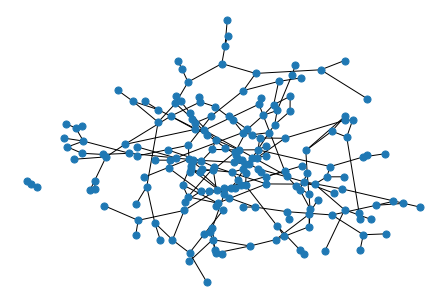

In [17]:
nx.draw(G, node_size=50)#, edge_color=list(gdf.weight), edge_cmap=plt.get_cmap('Greens_r'))

In [21]:
dijkstraPathNodes = nx.dijkstra_path(G, list(G.nodes())[10], list(G.nodes())[50], 'weight')
shortestPathNodes = nx.shortest_path(G, list(G.nodes())[10], list(G.nodes())[50], 'weight')

In [22]:
shortestPathMask = gdf['StartNode'].isin(shortestPathNodes) & gdf['EndNode'].isin(shortestPathNodes)
dijkstraPathMask = gdf['StartNode'].isin(dijkstraPathNodes) & gdf['EndNode'].isin(dijkstraPathNodes)

In [23]:
# OS Maps API (WMTS) endpoint path: /OSMapsAPI/wmts/v1?
wmts_endpoint = 'https://api.os.uk/maps/raster/v1/wmts?'

# Define WMTS parameters 
service = 'wmts'
request = 'GetTile'
version = '2.0.0'
style = 'default'
# Light style base map in Web Mercator projection (EPSG:3857)
layer = 'Light_3857'
tileMatrixSet = 'EPSG:3857'
tileMatrix = 'EPSG:3857:{z}'
tileRow = '{y}'
tileCol ='{x}'

# Represent WMTS parameters in a dictionary
params_wmts = {'key':apikey, 
              'service':service, 
              'request':request,
              'version':'2.0.0',
              'style':style,
              'layer':layer,
              'tileMatrixSet':tileMatrixSet,
              'tileMatrix':tileMatrix,
              'tileRow':tileRow,
              'tileCol':tileCol}

# Construct WMTS API path
wmts_path = wmts_endpoint + \
           ('key={key}&'
            'service={service}&'
            'request={request}&'
            'version={version}&'
            'style={style}&'
            'layer={layer}&'
            'tileMatrixSet={tileMatrixSet}&'
            'tileMatrix={tileMatrix}&'
            'tileRow={tileRow}&'
            'tileCol={tileCol}').format(**params_wmts)

print('=> Constructed OS Maps API URL: {}'.format(wmts_path))

=> Constructed OS Maps API URL: https://api.os.uk/maps/raster/v1/wmts?key=JydUr1HO7ejqBhw0YP19W3b1GonFwmzr&service=wmts&request=GetTile&version=2.0.0&style=default&layer=Light_3857&tileMatrixSet=EPSG:3857&tileMatrix=EPSG:3857:{z}&tileRow={y}&tileCol={x}


In [33]:
# Obtain current date-time

# Create a new Folium map
# Ordnance Survey basemap using the OS Data Hub WMTS centred on the boundary centroid location
# Zoom levels 7 - 16 correspond to the open data zoom scales only
m = folium.Map(location=[50.916438, -1.397284],
               min_zoom=7, 
               max_zoom=18,
               tiles=wmts_path,
               attr='Contains OS data © Crown copyright and database right 2020')

# Define feature style function
def style(feature):
    """
    Defines how GeoJSON features in a Leaflet overlay will be styled
    """
    return {'fillColor': '#ff1f5b',
            'color': '#ff1f5b',
            'weight': 1,
            'fillOpacity':.3}

# Define feature highlight function
def highlight(feature):
    """
    Defines how GeoJSON features in a Leaflet overlay will be highlighted on-hover
    """
    return {'weight':3, 
            'color':'#bf1747'}

def routeStyle(feature):
    """
    Defines how GeoJSON features in a Leaflet overlay will be styled
    """
    return {'fillColor': '#00CD6C',
            'color': '#00CD6C',
            'weight': 3,
            'fillOpacity':.3}

def dijkstraStyle(feature):
    """
    Defines how GeoJSON features in a Leaflet overlay will be styled
    """
    return {'fillColor': 'blue',
            'color': 'blue',
            'weight': 3,
            'fillOpacity':.3}

# Define feature layer using boundary GeoJSON returned by WFS
overlay = folium.GeoJson(data, 
                         #name=gdf_boundary['lad19nm'],
                         style_function=style,
                         highlight_function=highlight,
                        tooltip=folium.features.GeoJsonTooltip(
                            fields=['ID','RoadClassification',
                               'RouteHierarchy', 'FormOfWay', 
                               'RoadClassificationNumber', 'RoadName1', 'OperationalState',
                               'Directionality', 'Length', 
                               'ElevationGainInDir', 'ElevationGainInOppDir', 
                               'StartNode', 'EndNode']
                            )
                        )

shortestRoute = folium.GeoJson(gdf[shortestPathMask].to_json(),
                        style_function=routeStyle,
                        highlight_function=highlight,
                        tooltip=folium.features.GeoJsonTooltip(
                            fields=['ID','RoadClassification',
                               'RouteHierarchy', 'FormOfWay', 
                               'RoadClassificationNumber', 'RoadName1', 'OperationalState',
                               'Directionality', 'Length', 
                               'ElevationGainInDir', 'ElevationGainInOppDir', 
                               'StartNode', 'EndNode']
                            )
                      )


dijkstraRoute = folium.GeoJson(gdf[dijkstraPathMask].to_json(),
                        style_function=dijkstraStyle,
                        highlight_function=highlight,
                        tooltip=folium.features.GeoJsonTooltip(
                            fields=['ID','RoadClassification',
                               'RouteHierarchy', 'FormOfWay', 
                               'RoadClassificationNumber', 'RoadName1', 'OperationalState',
                               'Directionality', 'Length', 
                               'ElevationGainInDir', 'ElevationGainInOppDir', 
                               'StartNode', 'EndNode']
                            )
                      )

# Add feature layer to map
overlay.add_to(m)
shortestRoute.add_to(m)
dijkstraRoute.add_to(m)

# Fit bounds to the area of analysis
m.fit_bounds([[gdf.total_bounds[1], gdf.total_bounds[0]], [gdf.total_bounds[3], gdf.total_bounds[2]]])

# Return map object
m